# Strategy optimization and advanced performance measurement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Version 1.0
class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill") 
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        multiple = round(self.results.cstrategy[-1], 6)
        print("Strategy-Multiple: {}".format(multiple))
    
    def prepare_data(self, window):
        
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))

In [3]:
data = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
data

,EURUSD
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690
...,...
2019-12-29 22:00:00+00:00,1.119920
2019-12-30 04:00:00+00:00,1.119940
2019-12-30 10:00:00+00:00,1.120095


In [4]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
tc = 0.00007

In [5]:
tester = ConBacktester(filepath="intraday.csv", symbol=symbol, start=start, end=end, tc=tc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [6]:
tester.test_strategy(window = 3)

Strategy-Multiple: 1.018994


In [8]:
tester.results.cstrategy[-1]

1.0189942251079513

## Finding the optimal value for the "window" parameter

In [9]:
window_range = (1, 1001, 1) # (start, stop, step)
window_range

(1, 1001, 1)

In [10]:
windows = range(*window_range) # unpack tuple and create range

In [11]:
windows

range(1, 1001)

In [12]:
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [14]:
performance = []
for window in windows:
    tester.prepare_data(window)
    tester.run_backtest()
    performance.append(np.exp(tester.results.strategy.sum())) # calculate and store the multiple
performance

[0.963517236968365,
 0.9486395510353979,
 1.0189942251079516,
 0.8246643870440433,
 0.8594966694410051,
 0.9135118040559647,
 0.8847172753359587,
 0.9177288020041016,
 0.8849334916713126,
 0.9164141701100121,
 0.8955126340592936,
 0.9331514459896426,
 0.9762488297204391,
 0.9501362825244201,
 0.9389664420793701,
 0.9759164717062968,
 1.0326990764268977,
 1.0423267924050648,
 0.9696877734771253,
 1.0117729923088794,
 1.0012734159924286,
 1.0341362274469952,
 1.0312141395475498,
 1.0587868161149074,
 1.057439718205995,
 1.0073274892858672,
 1.0921646100454867,
 1.0867426298331129,
 1.1108891747694751,
 1.1383760016286768,
 1.1618928118167933,
 1.1187204942981919,
 1.1322318477267064,
 1.1637270440108516,
 1.178134705640984,
 1.2003307475489216,
 1.179449162789511,
 1.2163512320827623,
 1.1671358412105635,
 1.1729278305074826,
 1.1327913478546996,
 1.1964561101198754,
 1.1838582178949673,
 1.2607458724822662,
 1.2046573936396916,
 1.1754366215592134,
 1.1991541200714229,
 1.15876063656329

In [16]:
results_overview = pd.DataFrame(data = np.array(windows), columns = ["Windows"])
results_overview

,Windows
0,1
1,2
2,3
3,4
4,5
...,...
995,996
996,997
997,998
998,999


In [18]:
results_overview["Performance"] = performance
results_overview

,Windows,Performance
0,1,0.963517
1,2,0.948640
2,3,1.018994
3,4,0.824664
4,5,0.859497
...,...,...
995,996,0.990562
996,997,0.988896
997,998,0.988303
998,999,0.987310


In [19]:
results_overview.sort_values(by = "Performance", ascending=False)

,Windows,Performance
50,51,1.262038
43,44,1.260746
49,50,1.238808
54,55,1.235083
53,54,1.234555
...,...,...
10,11,0.895513
8,9,0.884933
6,7,0.884717
4,5,0.859497


In [20]:
best = results_overview.nlargest(1, "Performance")
best

,Windows,Performance
50,51,1.262038


In [22]:
window = best.Windows.iloc[0]
perf = best.Performance.iloc[0]
print("Window: {} | Multiple: {}".format(window, perf))

Window: 51 | Multiple: 1.2620379773848887


## Relationship between "window" and performance

Window == 51 is the best performing strategy in the past, **how reliable is that for the future?**

In [23]:
results_overview.set_index("Windows", inplace=True)
results_overview

,Performance
Windows,
1,0.963517
2,0.948640
3,1.018994
4,0.824664
5,0.859497
...,...
996,0.990562
997,0.988896
998,0.988303


<Axes: xlabel='Windows'>

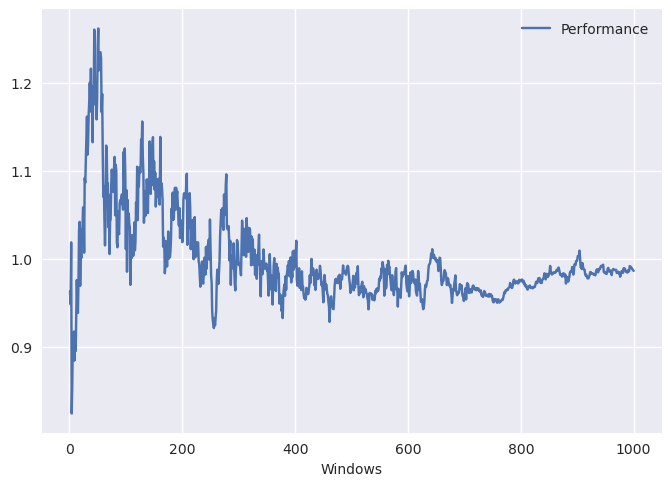

In [24]:
results_overview.plot()

In [26]:
results_overview.describe()

,Performance
count,1000.000000
mean,0.998966
std,0.052337
min,0.824664
25%,0.968633
50%,0.984317
75%,1.006572
max,1.262038


## Updating the ConBacktester Class (Optimization)

In [28]:
# Version 2.0 (Window Optimization)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the window parameter range.
        
    visualize_many:
        plots parameter values vs. performance. 
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        multiple = round(self.results.cstrategy[-1], 6)
        print("Strategy-Multiple: {}".format(multiple))
    
    def prepare_data(self, window):
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, window_range):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        '''
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(np.exp(self.results.strategy.sum()))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | Multiple: {}".format(window, round(perf, 6)))
        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | Performance vs Windows", fontsize = 15)
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("Multiple", fontsize = 15)
            plt.show()     

In [57]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
tc = 0.00007

In [58]:
tester = ConBacktester(filepath= "intraday.csv", symbol = symbol, start = start, end = end, tc = tc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [59]:
tester.optimize_strategy((1, 1001, 1))

Windows: 51 | Multiple: 1.262038
Strategy-Multiple: 1.262038


In [60]:
tester.window

51

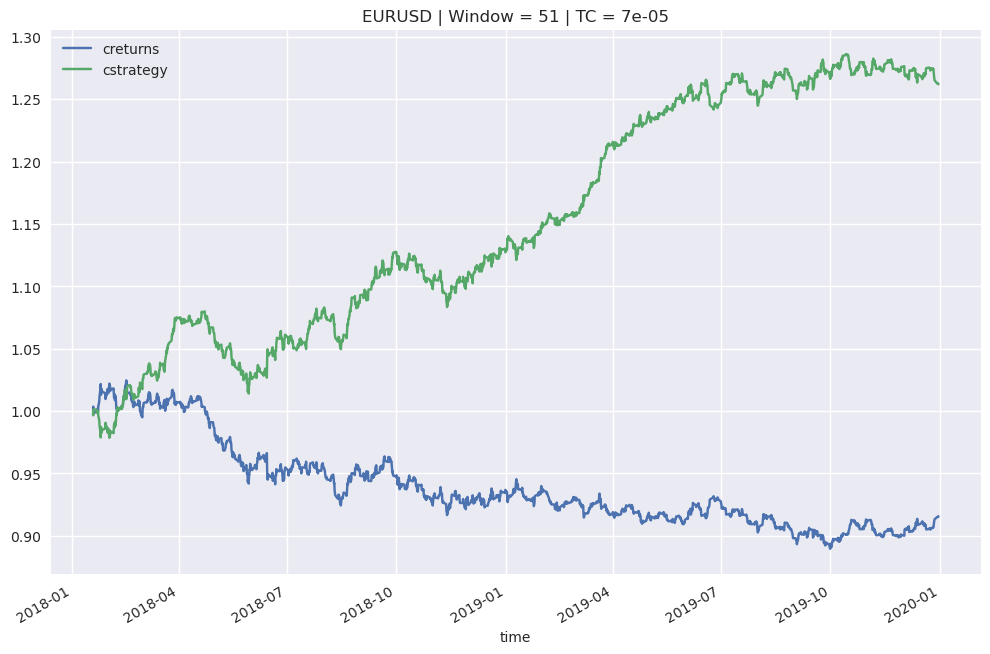

In [62]:
tester.plot_results()

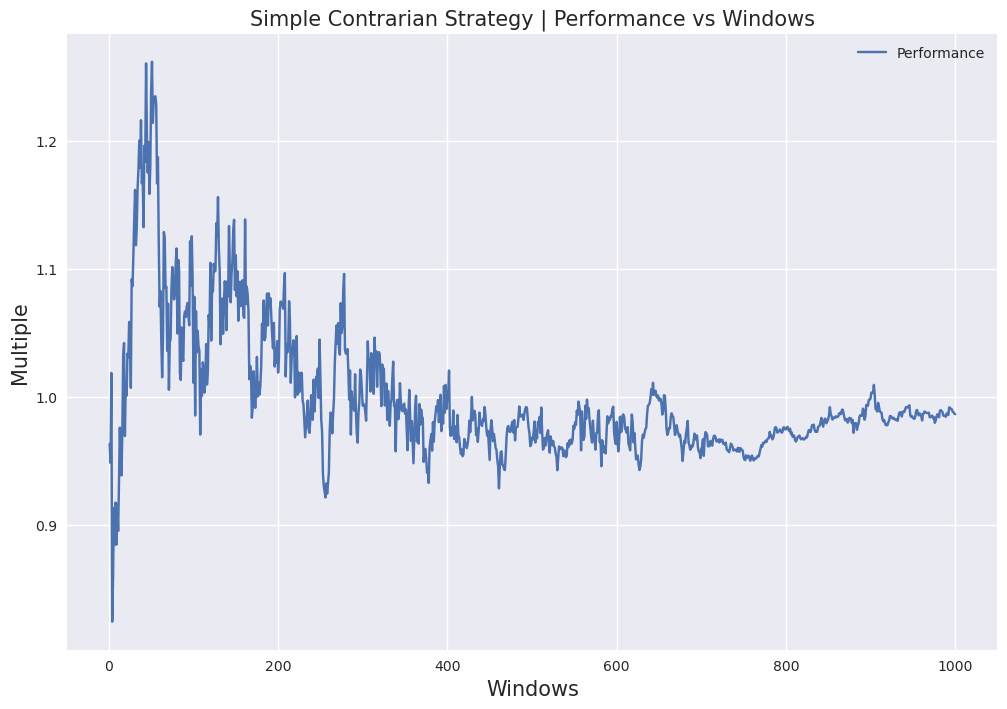

In [63]:
tester.visualize_many()

In [64]:
tester.results.trades.value_counts()

0.0    1876
2.0     142
Name: trades, dtype: int64

## Advanced Performance Reporting

In [65]:
tester.test_strategy(window = 51)

Strategy-Multiple: 1.262038


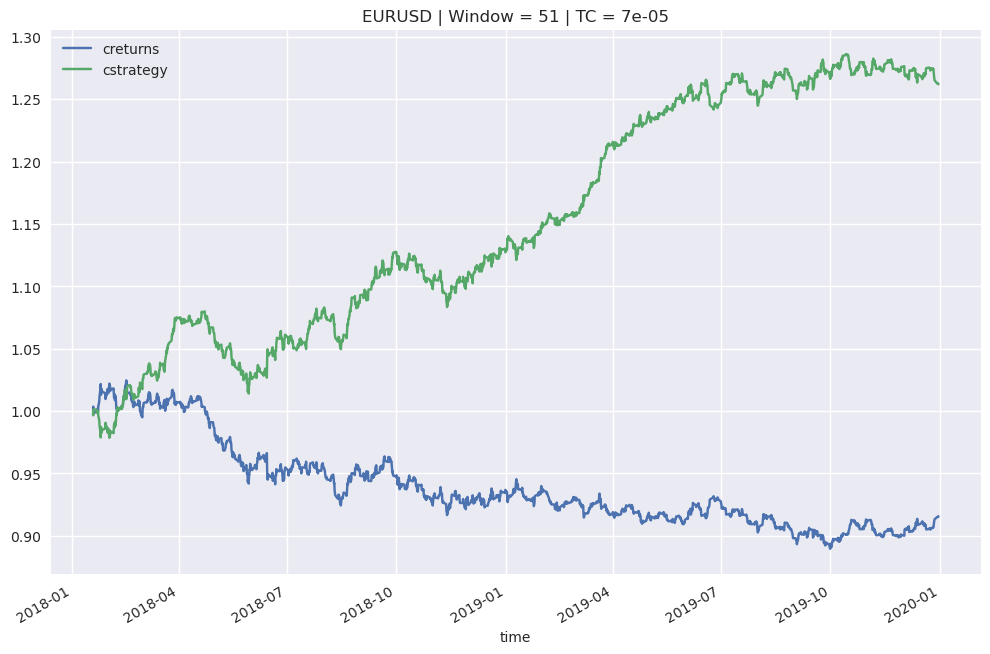

In [67]:
tester.plot_results()

In [68]:
tp_year = (tester.data.price.count() / ((tester.data.index[-1] - tester.data.index[0]).days / 365.25))
tp_year

1038.5542582417581

In [69]:
tester.results

,price,returns,roll_return,position,strategy,trades,creturns,cstrategy
time,,,,,,,,
2018-01-18 22:00:00+00:00,1.226670,0.002265,0.000316,-1.0,-0.002265,0.0,1.002267,0.997738
2018-01-19 04:00:00+00:00,1.228160,0.001214,0.000382,-1.0,-0.001214,0.0,1.003485,0.996527
2018-01-19 10:00:00+00:00,1.222085,-0.004959,0.000263,-1.0,0.004959,0.0,0.998521,1.001481
2018-01-19 16:00:00+00:00,1.222110,0.000020,0.000282,-1.0,-0.000020,0.0,0.998542,1.001461
2018-01-21 22:00:00+00:00,1.222900,0.000646,0.000308,-1.0,-0.000646,0.0,0.999187,1.000814
...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,0.000215,-1.0,-0.002092,0.0,0.915046,1.262528
2019-12-30 04:00:00+00:00,1.119940,0.000018,0.000192,-1.0,-0.000018,0.0,0.915062,1.262506
2019-12-30 10:00:00+00:00,1.120095,0.000138,0.000189,-1.0,-0.000138,0.0,0.915189,1.262331


### Multiple

In [70]:
def multiple(series):
    return np.exp(series.sum())

In [71]:
multiple(tester.results.strategy)

1.2620379773848887

### CAGR

In [74]:
def cagr(series):
    return np.exp(series.sum()) ** (1/((series.index[-1] - series.index[0]).days / 365.25)) - 1

In [75]:
cagr(tester.results.strategy)

0.12699561489564082

### Annualised mean return

In [76]:
def annualised_mean(series):
    return series.mean() * tp_year

In [77]:
annualised_mean(tester.results.strategy)

0.11977230256082305

### Annualised std

In [78]:
def annualised_std(series):
    return series.std() * np.sqrt(tp_year)

In [80]:
annualised_std(tester.results.strategy)

0.05989495330671505

### Sharpe Ratio

In [81]:
def sharpe(series):
    if series.std() == 0:
        return np.nan
    else:
        return series.mean() / series.std() * np.sqrt(tp_year)

In [82]:
sharpe(tester.results.strategy)

1.9997060845424337